# Classifying 400 Bird Species Using Deep Learning with PyTorch

<img src='https://images.unsplash.com/photo-1549608276-5786777e6587?ixlib=rb-1.2.1&raw_url=true&q=80&fm=jpg&crop=entropy&cs=tinysrgb&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170'>

This Deep Learning Project is presented in partial fulfillment of the award of Deep Learning Certification from  [jovian.ai](jovian.ai)

## Downloading the Dataset

In [ ]:
!pip install opendatasets -q

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/gpiosenka/100-bird-species')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omjiverma
Your Kaggle Key: ··········


100%|██████████| 1.49G/1.49G [00:11<00:00, 134MB/s]


## Importing Required Libraries

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [ ]:
import numpy as np

## Renaming Downloaded Directory

In [ ]:
os.rename('100-bird-species','Bird-Species')

In [ ]:
DATA_DIR = './Bird-Species'
files = os.listdir(DATA_DIR)
files

['test',
 'train',
 'valid',
 'birds latin names.csv',
 'my_csv-2-17-2022-1-17-48.csv',
 'birds.csv',
 'EfficientNetB4-BIRDS-0.99.h5',
 'class_dict.csv',
 'images to test']

## Converting dataset to Pytorch Dataset Form

**Imagefolder** is a generic data loader  assumes that all files are saved in folders. Pictures of the same category are stored in each folder. The folder name is class name.



In [ ]:
dataset = ImageFolder(DATA_DIR+'/train', transform = transforms.ToTensor())

## Checking shape of images

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.7059, 0.7294, 0.7333,  ..., 0.7098, 0.7098, 0.6980],
         [0.7137, 0.7451, 0.7490,  ..., 0.7137, 0.6980, 0.6980],
         [0.7294, 0.7647, 0.7686,  ..., 0.7216, 0.7059, 0.7176],
         ...,
         [0.6000, 0.6745, 0.6980,  ..., 0.7412, 0.7490, 0.6627],
         [0.6118, 0.6000, 0.6314,  ..., 0.7216, 0.7137, 0.6588],
         [0.6157, 0.6118, 0.6549,  ..., 0.6588, 0.7059, 0.5765]],

        [[0.6745, 0.6980, 0.7020,  ..., 0.7020, 0.7020, 0.7020],
         [0.6824, 0.7137, 0.7176,  ..., 0.7098, 0.6902, 0.7020],
         [0.6980, 0.7333, 0.7412,  ..., 0.7176, 0.7020, 0.7098],
         ...,
         [0.5373, 0.6235, 0.6471,  ..., 0.7451, 0.7412, 0.6549],
         [0.5490, 0.5490, 0.5804,  ..., 0.7412, 0.7255, 0.6706],
         [0.5529, 0.5490, 0.6039,  ..., 0.6863, 0.7333, 0.6000]],

        [[0.5843, 0.6078, 0.6118,  ..., 0.7843, 0.7843, 0.7804],
         [0.5922, 0.6235, 0.6353,  ..., 0.7804, 0.7725, 0.7804],
         [0.6157, 0.6510, 0.6667,  ..., 0.7882, 0.7725, 0.

## Function for viewing images from dataset using matplotlib

In [ ]:
def show_img(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  ABBOTTS BABBLER (0)


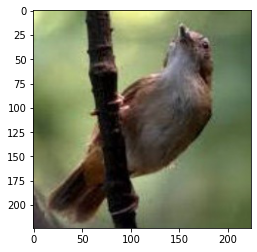

In [ ]:
show_img(*dataset[122])

Label:  ABBOTTS BOOBY (1)


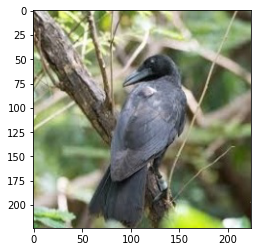

In [ ]:
show_img(*dataset[324])

## PyTorch data loaders

Working with huge datasets necessitates loading them all into memory at the same time. Due to the restricted amount of memory accessible in the system, we frequently have a memory outage. Furthermore, due to large datasets imported just once, the programmes execute slowly. Using DataLoader, PyTorch provides a mechanism for parallelizing the data loading process with automatic batching.


**Dataloader** has been used to parallelize the data loading as this boosts up the speed and saves memory.

**batch_size**  It refers to the number of samples in every batch.

**shuffle**  It is used when we want to reshuffle the data.

**num_workers** The number of processes for loading the data.

**pin_memory**  The location used by the GPU for giving fast access to data.

In [ ]:
batch_size = 112
dataset_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Show images in a grid

This function help us to view a batch of images at a time

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

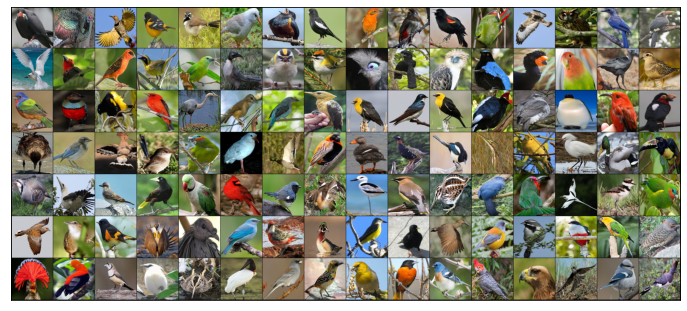

In [ ]:
show_batch(dataset_dl)

## DATA PREPARATION FOR TRAINING MODEL

We'll now prepare the data for use in the model. We want to make sure that all of the data, or images in this example, is similar. The data will then be augmented and normalised.

## Functions for Data Augmentation and Normalization
1. We can standardise all images to the size '224 x 224' by using the 'Resize' function from 'torchvision.transforms'.
2. The 'RandomHorizontalFlip' function flips the images horizontally at random, allowing the model to learn to anticipate alternative orientations.
3. The image will be converted to a tensor using 'ToTensor.'
4. 'Normalize' prevents pixel values from any one channel (RBG) from affecting losses and gradients disproportionally.



In [ ]:
# Transform the data (augmentation and normalization)
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))
train_tt = transforms.Compose([transforms.Resize((224, 224)), 
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize(*stats, inplace = True)
])

valid_tt = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(*stats)])
test_tt = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(*stats)])

## Create an ImageFolder with the normalization transformations for each dataset

In [ ]:
train_ds = ImageFolder(DATA_DIR+'/train', transform = train_tt)
valid_ds = ImageFolder(DATA_DIR + '/valid', transform = valid_tt)
test_ds = ImageFolder(DATA_DIR + '/test', transform = valid_tt)

### Images after norfmalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ABBOTTS BABBLER (0)


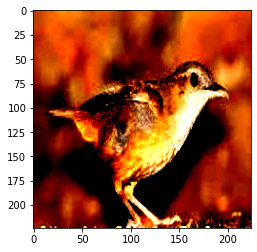

In [ ]:
show_img(*train_ds[120])

### Moving transformed dataset to the DataLoader

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 2, pin_memory = True)

## Denormalizing dataset

In [ ]:

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

# Function to show a batch of images
def show_batch_denorm(dl):
    for images, labels in dl:
        fig, ax = plt. subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_imgs = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_imgs, nrow = 16).permute(1, 2, 0).clamp(0, 1))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


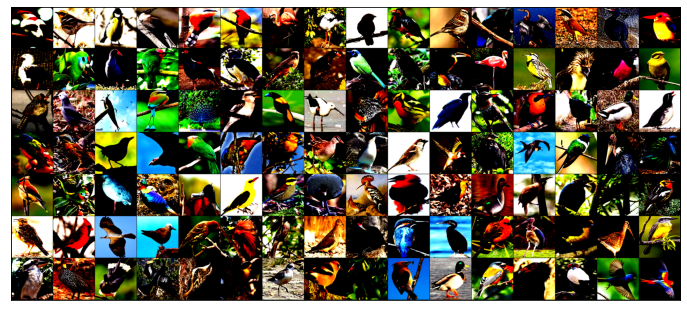

In [ ]:
# Batch of images after nomalization
show_batch(train_dl)

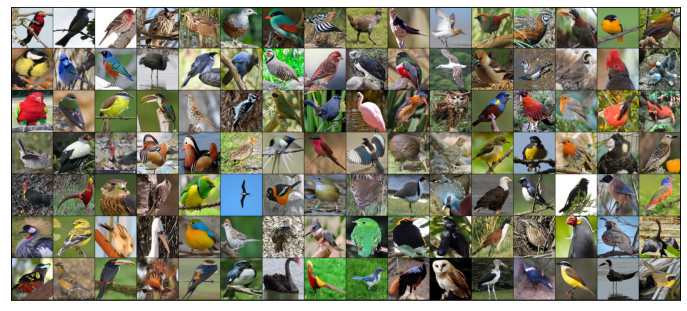

In [ ]:
# Batch of images after denormalization
show_batch_denorm(train_dl)

##Using GPU

Using a GPU instead of a CPU will allow the model to perform calculations significantly faster. If you're using Google Colab to execute this notebook, make sure the runtime type is GPU. The get default device and to device functions, as well as the DeviceDataLoader class, will be defined to move the model and data to the GPU.

In [ ]:
# Gets the device (CPU or GPU) currently in use
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Moves data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Class utilized as a wrapper, data yielder, and length argument
class DeviceDataLoader():
    def __init__ (self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
# Return the device currently in use (CPU or GPU)
device = get_default_device()
device

device(type='cuda')

Move the datasets to the identified device (hopefully the GPU (cuda) for faster computation).

In [ ]:
# Wrap the data loaders in DeviceDataLoaders
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

## Resnet Pretrained Neural Network

<img src="https://editor.analyticsvidhya.com/uploads/38371XTo6Q.png">

In [ ]:
from torchvision import models

class BirdsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = BirdsModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Finetuning the Pretrained Model

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.003548534819856286, 'val_loss': 6.262224197387695}]

### Training Parameters

In [ ]:
epochs = 5

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/522 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00759, train_loss: 2.3121, val_loss: 2.5348, val_acc: 0.4497


  0%|          | 0/522 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00950, train_loss: 1.4330, val_loss: 1.3244, val_acc: 0.6501


  0%|          | 0/522 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00611, train_loss: 0.9843, val_loss: 0.6921, val_acc: 0.8218


  0%|          | 0/522 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00188, train_loss: 0.5666, val_loss: 0.2671, val_acc: 0.9295


  0%|          | 0/522 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00000, train_loss: 0.2074, val_loss: 0.1343, val_acc: 0.9565
CPU times: user 13min 11s, sys: 11min 58s, total: 25min 9s
Wall time: 25min 35s


Here we see that with only 25 minute of training we have achieved an accuracy of 95.6%

## Model Performance Evaluation

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

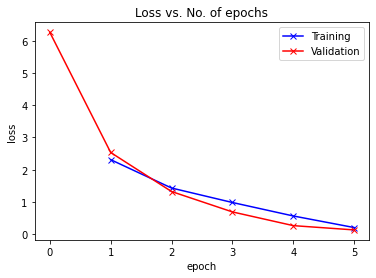

In [ ]:
plot_losses(history)

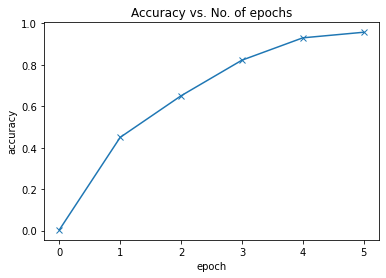

In [ ]:
plot_accuracies(history)

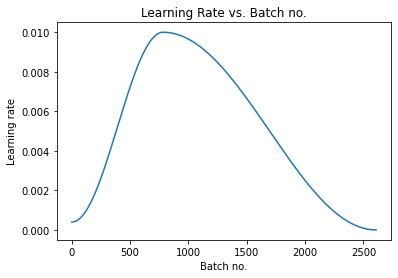

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), 'birds-classifier-resnet.pth')

###Predicting Images
Let's predict some images from the test dataset.

In [ ]:
# Denormalizes the image 
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]
def get_pred(test_ds[x]):
  img, label = test_ds[x]
  plt.imshow(denormalize(img, *stats).permute(1, 2, 0).clamp(0, 1))
  print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: ABYSSINIAN GROUND HORNBILL , Predicted: ABYSSINIAN GROUND HORNBILL


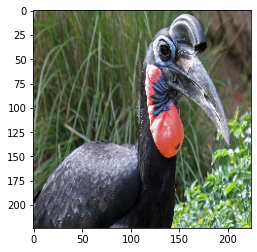

In [ ]:
get_pred(test_ds[10])

Label: AFRICAN CROWNED CRANE , Predicted: AFRICAN CROWNED CRANE


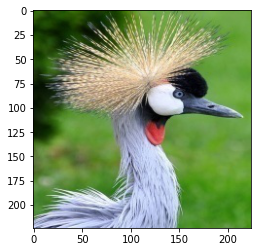

In [ ]:
get_pred(test_ds[18])

Label: ARARIPE MANAKIN , Predicted: ARARIPE MANAKIN


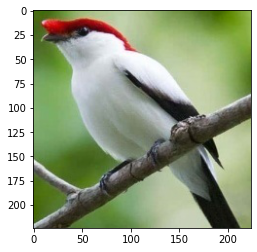

In [ ]:
get_pred(test_ds[150])

###Saving Model Weights

In [ ]:
torch.save(model.state_dict(), 'bird-classifier-resnet.pth')